In [1]:
import numpy as np
import random
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [3]:
#條誇號參數絕定其error
noise_model = get_noise(0.00)

In [4]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [5]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

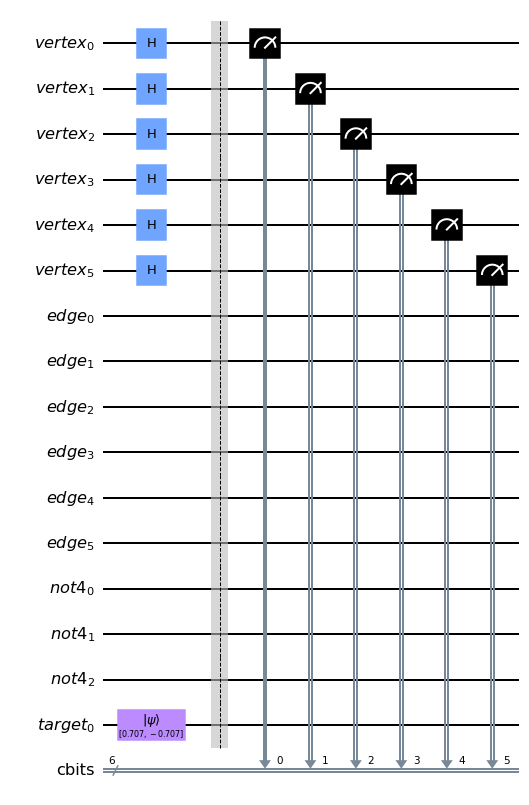

In [6]:
#example (v為vertex, e為edge)
# ex 1 
#v_list = [0,1,2,3,4]
#e_list = [[0,1],[1,2],[1,3], [1,4], [0,4]]

# ex 2
#v_list = [0,1,2,3,4,5,6,7,8,9]
#e_list = [[0,1],[0,4],[0,5],[1,2],[1,6],[2,3],[2,7],[3,4],[3,8],[4,9],[5,7],[5,8],[6,8],[6,9],[7,9]]

#ex 3
v_list = [0,1,2]
e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 9

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取4
xx = random.randint(0, 4)
for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

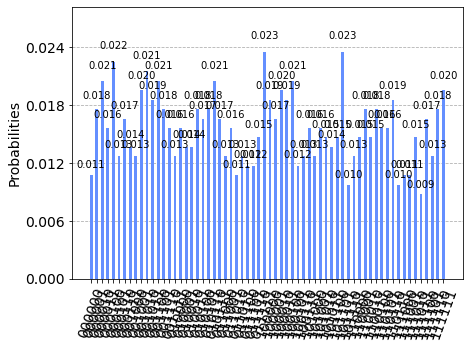

In [7]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

[['011111', 24], ['101101', 24], ['000100', 23], ['001010', 22], ['100100', 21], ['000010', 21], ['010110', 21], ['001100', 21], ['100010', 20], ['111111', 20], ['001001', 20], ['100000', 19], ['110110', 19], ['100011', 19], ['001011', 19], ['000001', 18], ['110001', 18], ['001101', 18], ['010101', 18], ['110011', 18], ['010011', 18], ['111110', 18], ['000110', 17], ['100001', 17], ['111100', 17], ['010111', 17], ['010100', 17], ['101001', 16], ['000011', 16], ['001110', 16], ['110101', 16], ['100111', 16], ['011001', 16], ['010000', 16], ['110100', 16], ['110000', 15], ['111010', 15], ['101100', 15], ['011110', 15], ['110010', 15], ['101010', 15], ['010010', 14], ['010001', 14], ['101011', 14], ['000111', 14], ['001000', 13], ['101111', 13], ['101000', 13], ['011011', 13], ['100110', 13], ['001111', 13], ['111101', 13], ['011000', 13], ['000101', 13], ['011100', 12], ['100101', 12], ['011101', 12], ['111000', 11], ['111001', 11], ['000000', 11], ['011010', 11], ['110111', 10], ['10111

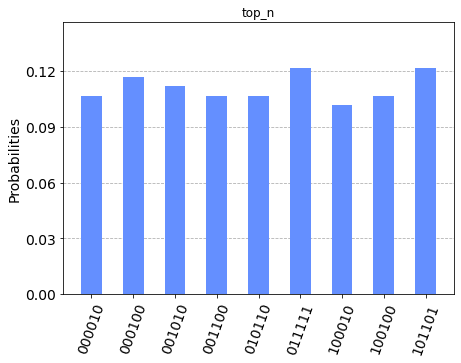

In [8]:
p1 = []
p2 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [9]:
print(counts)

{'101001': 16, '000110': 17, '110000': 15, '000011': 16, '111010': 15, '100000': 19, '001000': 13, '101111': 13, '100100': 21, '000001': 18, '011100': 12, '110001': 18, '001110': 16, '101000': 13, '011011': 13, '110110': 19, '111000': 11, '001010': 22, '000010': 21, '101100': 15, '110101': 16, '001101': 18, '111001': 11, '100110': 13, '011111': 24, '001111': 13, '010010': 14, '100010': 20, '111111': 20, '011110': 15, '100001': 17, '100101': 12, '100111': 16, '111101': 13, '011001': 16, '110111': 10, '001001': 20, '010110': 21, '110010': 15, '010101': 18, '111100': 17, '110011': 18, '010001': 14, '000100': 23, '000000': 11, '101011': 14, '101110': 10, '100011': 19, '010111': 17, '001100': 21, '010000': 16, '111011': 9, '000111': 14, '011101': 12, '011000': 13, '010100': 17, '000101': 13, '010011': 18, '110100': 16, '011010': 11, '111110': 18, '101010': 15, '001011': 19, '101101': 24}


In [10]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'001101': 13, '100000': 18, '100100': 11, '000111': 11, '001011': 18, '111001': 12, '100110': 19, '101001': 16, '010101': 14, '011101': 14, '101101': 19, '101000': 10, '001110': 16, '000110': 12, '100111': 17, '011000': 28, '010100': 15, '010000': 11, '111011': 14, '001100': 13, '010011': 17, '000101': 20, '101111': 15, '000001': 17, '101100': 18, '011110': 20, '110001': 17, '011100': 21, '001010': 14, '000010': 20, '011011': 17, '110110': 11, '000000': 12, '101011': 23, '111111': 14, '100010': 14, '011111': 19, '110010': 19, '010110': 16, '111000': 9, '111010': 17, '110101': 14, '010001': 18, '000100': 10, '000011': 16, '101110': 22, '110000': 11, '101010': 8, '111110': 15, '011010': 11, '111101': 24, '011001': 17, '110100': 11, '100011': 17, '010111': 16, '111100': 14, '110011': 20, '001000': 10, '110111': 13, '001001': 12, '010010': 13, '001111': 24, '100001': 18, '100101': 15}


[['011000', 28], ['111101', 24], ['001111', 24], ['101011', 23], ['101110', 22], ['011100', 21], ['000101', 20], ['011110', 20], ['000010', 20], ['110011', 20], ['100110', 19], ['101101', 19], ['011111', 19], ['110010', 19], ['100000', 18], ['001011', 18], ['101100', 18], ['010001', 18], ['100001', 18], ['100111', 17], ['010011', 17], ['000001', 17], ['110001', 17], ['011011', 17], ['111010', 17], ['011001', 17], ['100011', 17], ['101001', 16], ['001110', 16], ['010110', 16], ['000011', 16], ['010111', 16], ['010100', 15], ['101111', 15], ['111110', 15], ['100101', 15], ['010101', 14], ['011101', 14], ['111011', 14], ['001010', 14], ['111111', 14], ['100010', 14], ['110101', 14], ['111100', 14], ['001101', 13], ['001100', 13], ['110111', 13], ['010010', 13], ['111001', 12], ['000110', 12], ['000000', 12], ['001001', 12], ['100100', 11], ['000111', 11], ['010000', 11], ['110110', 11], ['110000', 11], ['011010', 11], ['110100', 11], ['101000', 10], ['000100', 10], ['001000', 10], ['11100

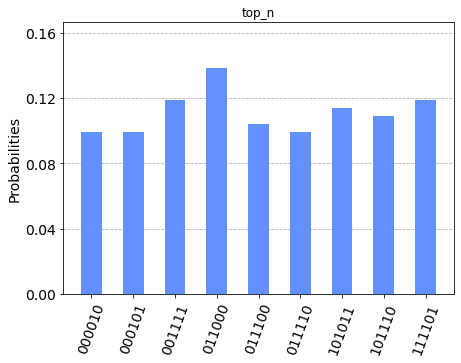

In [11]:
p3 = []
p4 = []
pause2 = results.get_counts()
pause2.clear()
di2 = dict.fromkeys(noisy_counts)
for i in di2.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
for i in range(top_n):
        b = p3[i]
        pause2.setdefault(b[0],b[1])
plot_histogram(pause2, title="top_n",bar_labels = False)

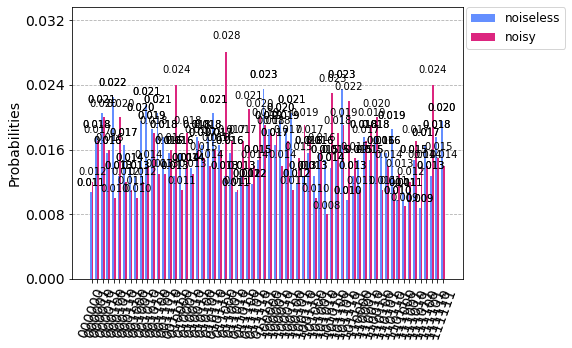

In [12]:
plot_histogram([counts, noisy_counts], legend=['noiseless', 'noisy'])

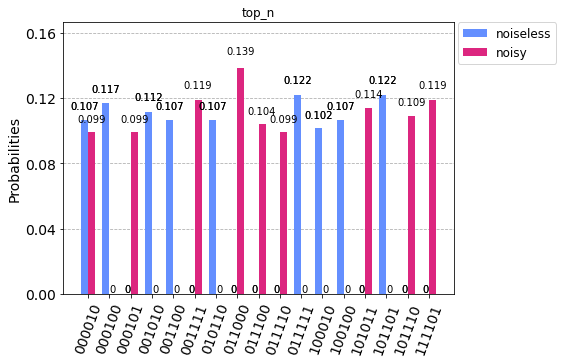

In [13]:
plot_histogram([pause, pause2], title="top_n", legend=['noiseless', 'noisy'])